In [8]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap

import warnings
warnings.filterwarnings('ignore')

In [24]:
with open("splits.pkl", "rb") as f:
    X_train, X_test, y_train, y_test, feature_names = pickle.load(f)

In [10]:
with open("rf_best.pkl", "rb") as f:
    rf_best = pickle.load(f)

y_pred = rf_best.predict(X_test)

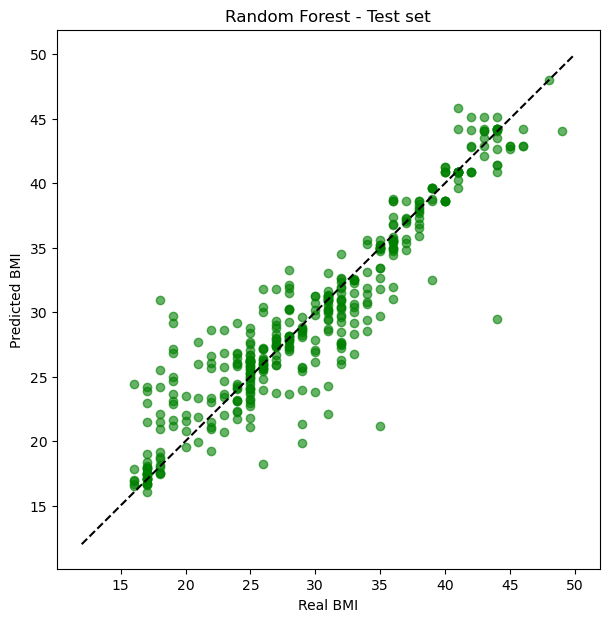

In [11]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6, color='green')
plt.plot([12,50],[12,50], 'k--') 
plt.title("Random Forest - Test set")
plt.xlabel("Real BMI")
plt.ylabel("Predicted BMI")

plt.show()

In [35]:
errors = np.abs(y_test - y_pred)
idx_max_error = np.argmax(errors)

print("Biggest error:")
print("-------------")
print("Real BMI:", y_test.iloc[idx_max_error])
print("Predicted BMI:", round(y_pred[idx_max_error]))

Biggest error:
-------------
Real BMI: 44
Predicted BMI: 29


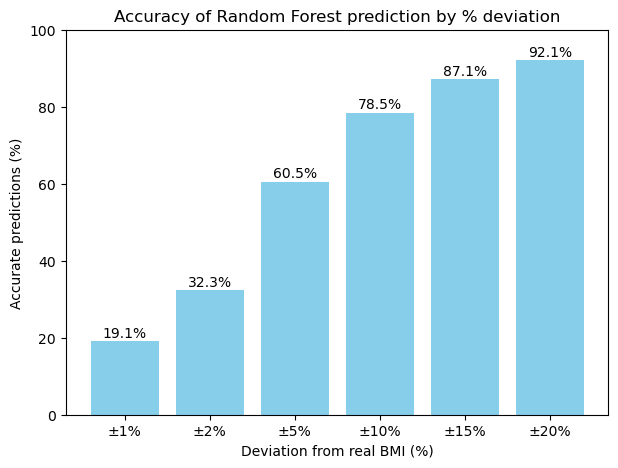

In [12]:
relative_error = np.abs(y_test - y_pred) / y_test * 100  

thresholds = [1, 2, 5, 10, 15, 20]  
accuracy = [(relative_error <= t).mean() * 100 for t in thresholds]

plt.figure(figsize=(7,5))
plt.bar([f"±{t}%" for t in thresholds], accuracy, color='skyblue')
plt.ylabel("Accurate predictions (%)")
plt.xlabel("Deviation from real BMI (%)")
plt.title("Accuracy of Random Forest prediction by % deviation")
plt.ylim(0,100)
for i, val in enumerate(accuracy):
    plt.text(i, val+1, f"{val:.1f}%", ha='center')
plt.show()


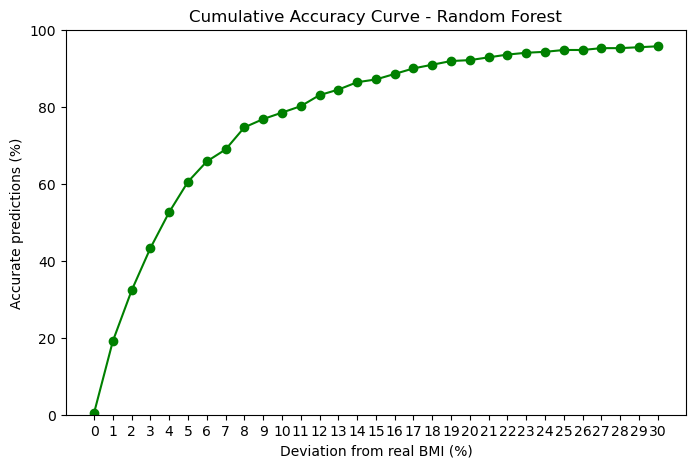

In [13]:
relative_error = np.abs(y_test - y_pred) / y_test * 100

thresholds = np.arange(0, 31, 1)  # 0,1,2,...,20%
accuracy = [(relative_error <= t).mean() * 100 for t in thresholds]

plt.figure(figsize=(8,5))
plt.plot(thresholds, accuracy, marker='o', color='green')
plt.title("Cumulative Accuracy Curve - Random Forest")
plt.xlabel("Deviation from real BMI (%)")
plt.ylabel("Accurate predictions (%)")
plt.xticks(thresholds)
plt.ylim(0,100)
plt.show()


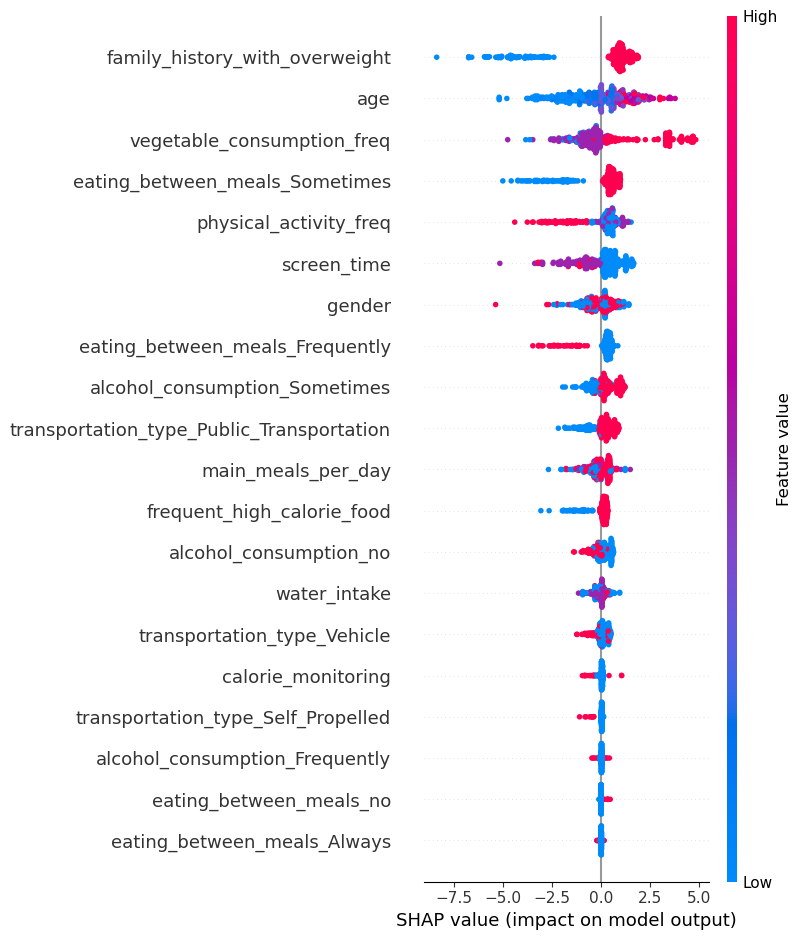

In [19]:
rf_model = rf_best.named_steps['randomforestregressor']
X_test_scaled = rf_best.named_steps['standardscaler'].transform(X_test)

explainer = shap.TreeExplainer(rf_model, feature_perturbation="tree_path_dependent")

shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

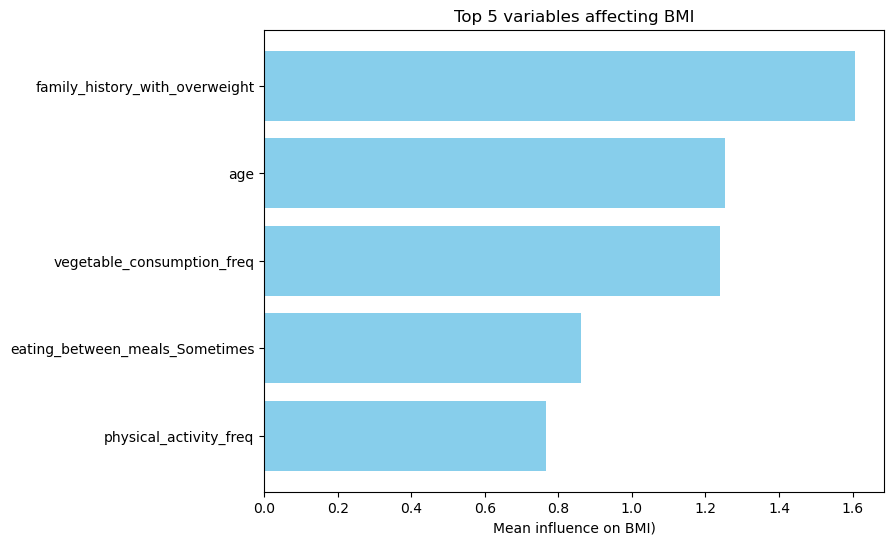

In [23]:
if X_test_scaled.shape[0] > 500:
    idx = np.random.RandomState(123).choice(X_test_scaled.shape[0], 500, replace=False)
    X_sample = X_test_scaled[idx]
else:
    X_sample = X_test_scaled

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_sample)

shap_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": shap_importance
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
plt.barh(importance_df["feature"][:5][::-1], importance_df["importance"][:5][::-1], color="skyblue")
plt.xlabel("Mean influence on BMI)")
plt.title("Top 5 variables affecting BMI")
plt.show()
